In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from numpy import mean, std

# read data from excel
data = pd.read_excel('mugs_segmentation_data.xlsx')

# Columns
data.columns = data.columns.str.replace(' ', '')

## Part A: Product affinity based segmentation

(1) Compute and report the characteristics of the affinity based segment for Product 3 (our candidate as given above). Report the characteristics in terms of the following descriptors: pPr30, pPr10, pPr05, pIn0.5, pIn1, pIn3, pCp12, pCp20, pCp32, pClD, pClF, pClE, pCnSl, pCnSp, pCnLk, pBrA, pBrB, pBrC, IPr, Iin, ICp, ICl, Icn, IBr, and the demographics income, age, sports and gradschl. For this you need to compute the weighted average of columns 2 through 29 weighted by the purchase probability of buying our product as given in column 32. You are  to load the data into python or R and compute the weighted averages in R or python; this is to help you build familiarity with these languages and prepare you better for your job.

In [134]:
# Loglift for product 3
for cols in data.columns[1:29]:
    data['P3*' + cols] = data['P3'] * data[cols]

(2) Repeat the step above for the product of brand A and the product for brand B, this time using the purcahse probabilities of buying those products as given in columns 30 and 31.  Compute also the overall mean for each descriptor (this done by a simple average of each descriptor across all 311 customers). Compute the log-lifts for all variables for the affinity based segment for each product and focus on the large positive and negative numbers to figure out how each segment is different from the other segments and the overall population average (A common thumb rule is to take base 10 absolute log lifts greater than 0.04  to be noteworthy and greater than 0.08 to be very noteworthy). You will use these in the next step to come up with a verbal description that characterizes each segment.)

In [135]:
# Loglift for product 1
for cols in data.columns[1:29]:
    data['P1*' + cols] = data['P1'] * data[cols]

In [136]:
# Loglift for product 2
for cols in data.columns[1:29]:
    data['P2*' + cols] = data['P2'] * data[cols]

In [137]:
# Computing loglifts for each variable
loglift = pd.DataFrame(index = data.iloc[:, 1:29].columns)
loglift['Mean'] = list(data.iloc[:, 1:29].mean())
# loglift['P1_sum'] = list(data.iloc[:, 1:29].sum())
# loglift['P2_sum'] = list(data.iloc[:, 29:57].sum())
# loglift['P3_sum'] = list(data.iloc[:, 57:85].sum())
loglift['P1_weightsum'] = list(data.iloc[:, 60:88].sum())
loglift['P2_weightsum'] = list(data.iloc[:, 88:116].sum())
loglift['P3_weightsum'] = list(data.iloc[:, 32:60].sum())
loglift['P1_weightavg'] = loglift['P1_weightsum'] / data['P1'].sum()
loglift['P2_weightavg'] = loglift['P2_weightsum'] / data['P2'].sum()
loglift['P3_weightavg'] = loglift['P3_weightsum'] / data['P3'].sum()
loglift['Prod1_loglift'] = np.log10(loglift['P1_weightavg'] / loglift['Mean'])
loglift['Prod2_loglift'] = np.log10(loglift['P2_weightavg'] / loglift['Mean'])
loglift['Prod3_loglift'] = np.log10(loglift['P3_weightavg'] / loglift['Mean'])

In [138]:
# Finding noteworthy variables
loglift.iloc[:, 7:11].style.applymap(lambda x: 'background-color : #108700' if x > 0.08 # Very Noteworthy (Dark Green)
                                         else 'background-color : #19CC00' if x > 0.04 and x <= 0.08 # Noteworthy (Light Green)
                                         else 'background-color : #DF0000' if x < -0.04 and x >= -0.08 # Noteworthy (Light Red)
                                         else 'background-color : #980000' if x < -0.08 # Very Noteworthy (Dark Red)
                                         else '')

,Prod1_loglift,Prod2_loglift,Prod3_loglift
pPr30,0.000000,0.000000,0.000000
pPr10,-0.029599,0.031798,-0.021240
pPr05,0.000000,0.000000,0.000000
pIn0.5,0.000000,0.000000,0.000000
pIn1,-0.002245,0.009720,-0.013918
pIn3,0.000000,0.000000,0.000000
pCp12,0.015175,-0.006356,-0.008038
pCp20,0.001837,-0.000531,-0.001320
pCp32,-0.011492,0.008799,-0.001241
pClD,0.000000,0.000000,0.000000


(3) Use your findings from Step 2 above to come up with a verbal description and a persona story that characterizes each segment. The persona  story gives a mental image to the marketing manager, not only in terms of the descriptors in the dataset, but also in terms of plausible hypothesized characteristics that go beyond the descriptors available. The suggested length for the persona description for each segment is 2-5 sentences. If you do use generative AI tools for this part of the HW (and indeed this is the part in this HW where such tools may help the most) then please be sure to document your work and submit for extra credit via Optional Task 3.

## Part B: Classical segmentation

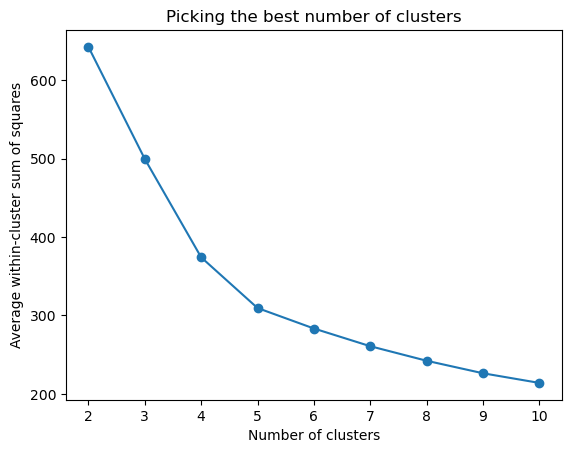

In [139]:
# Choose columns
X = data.iloc[:, 1:25]

# Store average within-cluster sum of squares
ave_within_cluster_mean_sum_of_squares = []

# Select best k
for k in range(2, 11):
    np.random.seed(410014)
    # X is an np.array containing the data
    kmeansModel = KMeans(n_clusters = k, n_init = 50, max_iter = 100)
    kmeansModel.fit(X)
    ave_within_cluster_mean_sum_of_squares = np.append(ave_within_cluster_mean_sum_of_squares, (kmeansModel.inertia_) / X.shape[0])
    # alternatively you compute it manually as follows
    # ave_within_cluster_mean_sum_of_squares = sum(np.min(cdist(X, kmeansModel.cluster_centers_, 'euclidean')**2, axis=1)) / X.shape[0])

# Graph
plt.plot(range(2, 11), ave_within_cluster_mean_sum_of_squares, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Picking the best number of clusters')
plt.show()

(1) Compute and report the characteristics of all segments. Report the characteristics in terms of the average value, for each segment, of each of the following variables: pPr30, pPr10, pPr05, pIn0.5, pIn1, pIn3, pCp12, pCp20, pCp32, pClD, pClF, pClE, pCnSl, pCnSp, pCnLk, pBrA, pBrB, pBrC,IPr, Iin, ICp, ICl, ICn, IBr. Also, do profiling in terms of the demographics: income, age, sports and gradschl. "Profiling" means reporting the average value, for each segment, of each  descriptor that was excluded from the kmeans analysis's inputs. In this case, the excluded variables are:income, age, sports and gradschl. Finally, report the percentage of customers in each segment.

In [140]:
# Choose columns
X = data.iloc[:, 1:25]
k = 4

np.random.seed(410014)
kmeans = KMeans(n_clusters = k, n_init = 50, max_iter = 100)
kmeans.fit(X)

# Add cluster column to the data
data['Cluster'] = kmeans.labels_

# Cluster Means
cluster_means = data.iloc[:, np.r_[1:29, 116]].groupby('Cluster').mean().T

# Columns
c = []
d = []
for i in range(1, k+1):
    c = np.append(c, 'Cluster ' + str(i))
    d = np.append(d, len(data.loc[data.Cluster == i-1])/len(data)*100)

cluster_means.columns = c
cluster_means.loc['%customers'] = d
cluster_means

# ############# Quantitative Analysis

# # Calculating net market share of each product
# p1 = []
# p2 = []
# p3 = []
# for i in range(k):
#     p1 = np.append(p1, data.loc[data.Cluster == i].P1.mean())
#     p2 = np.append(p2, data.loc[data.Cluster == i].P2.mean())
#     p3 = np.append(p3, data.loc[data.Cluster == i].P3.mean())

# # Print net shares
# print('Net Market Share of Product 1: ', p1.mean())
# print('Net Market Share of Product 2: ', p2.mean())
# print('Net Market Share of Product 3: ', p3.mean())

,Cluster 1,Cluster 2,Cluster 3,Cluster 4
pPr30,1.000000,1.000000,1.000000,1.000000
pPr10,5.186441,5.558621,5.134615,4.709091
pPr05,7.000000,7.000000,7.000000,7.000000
pIn0.5,1.000000,1.000000,1.000000,1.000000
pIn1,3.745763,4.068966,4.057692,4.272727
pIn3,7.000000,7.000000,7.000000,7.000000
pCp12,3.254237,2.882759,2.788462,4.109091
pCp20,5.610169,5.055172,5.423077,5.745455
pCp32,3.457627,4.268966,4.115385,3.145455
pClD,1.000000,1.000000,1.000000,1.000000


(2) Compute the log-lifts for all variables for all segments and focus on the large positive and negative numbers  to figure out how each segment is different from the other segments and the overall population average. You will use these in the next step to come up with a verbal description that characterizes each segment.  The log lift for any variable "x" for any segment "s" is  Log( (unweighted average of "x" across all persons within segment "s")/(unweighted average of x across all persons regardless of segment)).

In [141]:
# Computing loglifts for each variable
log_lift = pd.DataFrame(index = data.iloc[:, 1:29].columns)
log_lift['Mean'] = list(data.iloc[:, 1:29].mean())

for i in range(k):
    log_lift['cluster' + str(i+1) + '_mean'] = list(data.iloc[:, 1:29].loc[data.Cluster == i].mean())
    log_lift['cluster' + str(i+1) + '_loglift'] = np.log10(log_lift['cluster' + str(i+1) + '_mean']/log_lift['Mean'])

In [142]:
# Finding noteworthy variables
log_lift.iloc[:, 2::2].style.applymap(lambda x: 'background-color : #108700' if x > 0.08 # Very Noteworthy (Dark Green)
                                         else 'background-color : #19CC00' if x > 0.04 and x <= 0.08 # Noteworthy (Light Green)
                                         else 'background-color : #DF0000' if x < -0.04 and x >= -0.08 # Noteworthy (Light Red)
                                         else 'background-color : #980000' if x < -0.08 # Very Noteworthy (Dark Red)
                                         else '')

,cluster1_loglift,cluster2_loglift,cluster3_loglift,cluster4_loglift
pPr30,0.000000,0.000000,0.000000,0.000000
pPr10,-0.006684,0.023414,-0.011046,-0.048616
pPr05,0.000000,0.000000,0.000000,0.000000
pIn0.5,0.000000,0.000000,0.000000,0.000000
pIn1,-0.033035,0.002909,0.001704,0.024130
pIn3,0.000000,0.000000,0.000000,0.000000
pCp12,0.013541,-0.039100,-0.053544,0.114837
pCp20,0.021105,-0.024135,0.006375,0.031454
pCp32,-0.051247,0.040298,0.024385,-0.092342
pClD,0.000000,0.000000,0.000000,0.000000


(3) Use your findings from Step 2 above to come up with a verbal description and a persona story that characterizes each segment. The persona  story gives a mental image to the marketing manager  not only in terms of the descriptors in the dataset, but also in terms of plausible hypothesized characteristics that go beyond the descriptors available.

## Optional Task 1: Visualization in Classical segmentation. This is an Optional/Extra Credit Question.

[0.17000343 0.11902968]


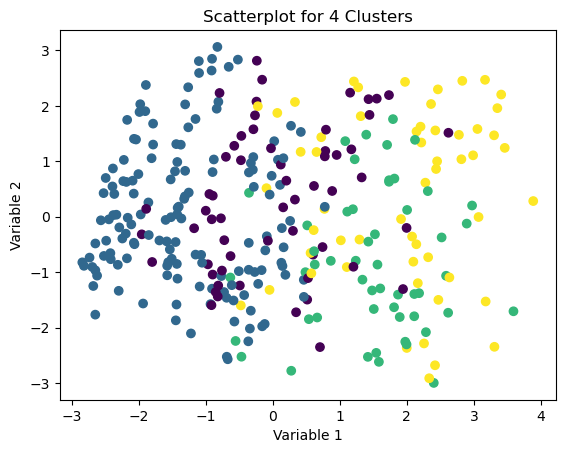

In [148]:
# Choose columns
X = data.iloc[:, 1:25]

np.random.seed(410014)
# X is an np.array containing the data
kmeansModel = KMeans(n_clusters = 4, n_init = 50, max_iter = 100)
kmeansModel.fit(X)
labels = kmeansModel.labels_

pca_2 = PCA(2)
Xopt = X.loc[:, X.var() != 0]

# Standardize the X matrix to make PCA operate on correlations instead of covariances
X_std = (Xopt - mean(Xopt, axis = 0)) / std(Xopt, axis = 0) # or some other modification of X or Xopt
X_std = X_std.fillna(0)
plot_columns = pca_2.fit_transform(X_std)
print(pca_2.explained_variance_ratio_)
plt.scatter(x = plot_columns[:, 0], y = plot_columns[:, 1], c = labels)
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.title('Scatterplot for 4 Clusters')
plt.show()
